In [1]:
import numpy as np
import pandas as pd
from sail.models.sklearn.linear_model import SGDClassifier
from sail.pipeline import SAILPipeline
from sklearn.impute import SimpleImputer
from sail.transformers.river.preprocessing import StandardScaler

#### Load Data


In [2]:
X = pd.read_csv("../../datasets/agrawal.csv").head(5000)

y = X["class"]
X.drop("class", axis=1, inplace=True)

#### Model Definition


In [3]:
sgd_classifier = SGDClassifier(max_iter=100, tol=1e-3)

#### Create SAIL Pipeline


In [4]:
steps = [
    ("Imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("standard_scalar", StandardScaler()),
    ("classifier", sgd_classifier),
]
sail_pipeline = SAILPipeline(steps=steps, verbosity_level=1)

#### Train Test Split


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

#### Start Incremental Training


In [6]:
y_preds = []
y_true = []
batch_size = 1

for start in range(0, X_train.shape[0], batch_size):
    end = start + batch_size

    X = X_train.iloc[start:end]
    y = y_train.iloc[start:end]

    sail_pipeline.partial_fit(X, y, classifier__classes=[1, 0])


    
>> Epoch: 1 | Samples Seen: 0 -------------------------------------------------------------------------------------
SAIL Pipeline Partial fit: 100%========== [Steps: 3/3, ETA: 00:00<00:00, Elapsed:0.012s, Batch Size=10, P_Score=0]             

    
>> Epoch: 2 | Samples Seen: 10 -------------------------------------------------------------------------------------
SAIL Pipeline Partial fit: 100%========== [Steps: 3/3, ETA: 00:00<00:00, Elapsed:0.005s, Batch Size=10, P_Score=0.4]             

    
>> Epoch: 3 | Samples Seen: 20 -------------------------------------------------------------------------------------
SAIL Pipeline Partial fit: 100%========== [Steps: 3/3, ETA: 00:00<00:00, Elapsed:0.008s, Batch Size=10, P_Score=0.55]             

    
>> Epoch: 4 | Samples Seen: 30 -------------------------------------------------------------------------------------
SAIL Pipeline Partial fit: 100%========== [Steps: 3/3, ETA: 00:00<00:00, Elapsed:0.006s, Batch Size=10, P_Score=0.6]    

#### Save SAIL Pipeline


In [7]:
sail_pipeline.save(".")

'./sail_pipeline'

#### Load SAIL Pipeline


In [8]:
sail_new_pipeline = SAILPipeline.load(".")

SAIL Pipeline Progressive Score: 100%========== [Points: 3490/3490, Elapsed:0.0065s, Metric=Accuracy, Batch Size=3490, P_Score=0.571]


#### Make Prediction on the Hold out set


In [9]:
y_preds = []
y_true = []
batch_size = 100

for start in range(0, X_test.shape[0], batch_size):
    end = start + batch_size

    X = X_test.iloc[start:end]
    y = y_test.iloc[start:end]

    preds = sail_new_pipeline.predict(X)
    y_preds.extend(list(preds))
    y_true.extend(list(y))

#### Classification Report


In [10]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67       992
           1       0.34      0.32      0.33       508

    accuracy                           0.56      1500
   macro avg       0.50      0.50      0.50      1500
weighted avg       0.55      0.56      0.56      1500



#### Plot confusion matrix


<Axes: >

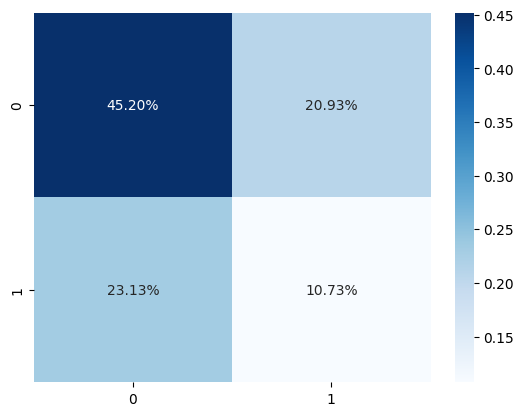

In [11]:
import seaborn as sns

cf_matrix = confusion_matrix(y_true, y_preds)
sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt=".2%", cmap="Blues")